## Notebook to implement importance sampling procedure for ages estimated under neutrality
##### Feb, 2023

In [5]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [431]:
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims/')
dft = pd.read_csv('outfiles/ConstantSize100_id1.9.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
dft['empty'] = ''
dft['sXl'] = (dft['Xl']*200).astype('int')
dft['al'] = 80000+1 - dft['al']
dft['al'] = dft['al'].astype('int')
dft = dft.iloc[:,1:]
datt = dft.to_numpy()

SMS = np.zeros((80000,200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(datt)):
    SMS[datt[i,2],datt[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.ylim((0,12000))

sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'gens':80000},200)) 

     fun: 743.6183
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 34
     nit: 23
 success: True
       x: -96.30200239847964

In [288]:
## inferring selection coefficients using estimated ages from Relate
## (can also build in an inference framework in which we randomly sample from a dist of posterior)
relest = np.zeros((datt.shape[0],2))
for ial, al in enumerate(datt[:,3]):
    relout = pd.read_csv("msselfiles/relfiles/outfiles/out10.0_{}.mut".format(int(al)),delimiter=';')
    relest[ial,0] = 1 if (relout['age_begin'][relout['pos_of_snp']==500000]==0).bool() else relout['age_begin'][relout['pos_of_snp']==500000]
    relest[ial,1] = relout['age_end'][relout['pos_of_snp']==500000]

# gevest = np.zeros((datt.shape[0],1))
# for ial, al in enumerate(datt[:,3]):
#     try:
#         gevout = pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(int(al)),delimiter=' ')
#     except:
#         gevout = pd.DataFrame(np.full((1,5),np.nan))
#     gevest[ial,0] = gevout.iloc[0,4]

In [296]:
# np.int_(rng.uniform(relest[-2:,0],relest[-2:,1]))
# pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(16004057),delimiter=' ')

(495, 2)

In [308]:
## running it on the midpoint
# datt = np.append(datt, np.int_(relest.mean(axis=1)).reshape(-1,1), 1)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,6],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# gamest = [sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x]

# running it on a uniform draw from the distribution
# for reps in range(20):
#     datt[:,6] = np.int_(rng.uniform(relest[:,0]+1,relest[:,1]))
#     SMS = np.zeros((80000,200+1),dtype='int16')
#     mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
#     for i in range(len(datt)):
#         SMS[datt[i,6],datt[i,5]] += 1
#     SMSmask = np.ma.array(SMS,mask=mask)

#     gamest.append(sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x)

-15.491195871844484

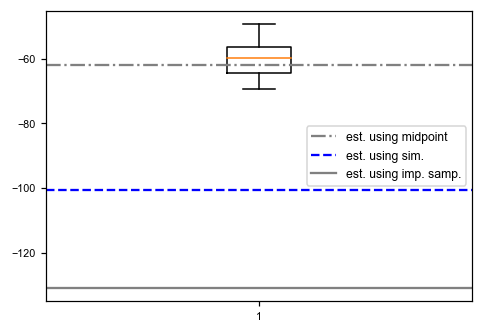

In [234]:
# plt.boxplot(np.random.normal(-61,5,size=20)); plt.axhline(-62,color='grey',ls='-.',label='est. using midpoint'); plt.axhline(-100.62,color='b',ls='--',label='est. using sim.'); plt.axhline(-131,color='grey',label='est. using imp. samp.'); plt.legend()
# np.random.normal(-62,8,size=20)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     if datt[i,7]==0:
#         continue
#     SMS[datt[i,7],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

### Importance sampling scheme method

Below is code to deal with the underestimation of $\gamma$ for higher values, as ages are estimated under the neutral prior. 

In [258]:
def get_ll_import_samp(g, opts, n=200):
    # adat is a matrix S x #, where S is total seg sites & # is resampled ages
    # fdat is a vector S
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], opts['theta'], {})[::-1]
    fsa[fsa<0] = -fsa[fsa<0]  
    S = opts['adat'].shape[0]

    fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], opts['theta'], {})[::-1]

    res = sp.stats.poisson.logpmf(S,fsa.sum())
    fsasum = np.sum(fsa)
    fsasum0 = np.sum(fsa0)

    res1 = 0
    temp = np.zeros(opts['adat'].shape[1])
    for l in range(S):
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],:])) + np.log(np.sum(fsa[opts['adat'][l,i],:])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i],:])/fsasum0)
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -(res+res1)

In [290]:
gamest = np.zeros((3,12))
for id, numdraws in enumerate([1,10,100]):
    for n in range(10):
        adat = np.zeros((len(datt),numdraws),dtype='int') # 20 draws from the uniform dist
        for i in range(len(adat)):
            adat[i,:] = rng.integers(relest[i,0]+1,relest[i,1]+1,size=numdraws)
        gamest[id,n] = sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':datt[:,5],'adat':adat,'gens':80000,'N':10000,'theta':400})).x
# fsa = run_mom_iterate_constant(8000, 200, -100/10000, 10000, 400, {})[::-1]
# fsa0 = run_mom_iterate_constant(8000, 200, 0, 10000, 400, {})[::-1]
# for i in range(15):
#     temp[i] = np.log(fsa[adat[l,i],datt[l,5]]/np.sum(fsa[:,datt[l,5]])) + np.log(np.sum(fsa[adat[l,i],:])/np.sum(fsa)) - np.log(np.sum(fsa0[adat[l,i],:])/np.sum(fsa0))
# sp.special.logsumexp(temp,b=1/15)

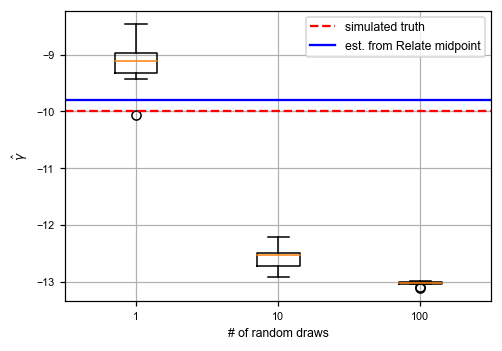

In [307]:
# plt.plot([1,5,10,20,50,200],[-62,-90,-92,-98,-105,-105.5],'k-o'); plt.grid(); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--')
# plt.boxplot(np.vstack((gamest,[-106.46879490781772, -106.63533318585628, -106.59984482503617, -105.71164004240123, -106.60735265236947, -105.96117457813611, -105.4330728291148, -106.35381183019143, -105.9841342938603, -106.17026426936992, -105.6041233148638, -105.94080087277358])).T); plt.xticks(ticks=range(1,5),labels=[2,10,50,200]); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--',label='simulated truth'); plt.grid(); plt.axhline(-62,color='b',label='est. from Relate midpoint'); plt.legend(loc='center right')
plt.boxplot(gamest[:,:10].T+5.98); plt.xticks(ticks=range(1,4),labels=[1,10,100]); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-10,color='red',ls='--',label='simulated truth'); plt.grid(); plt.axhline(-9.8,color='b',label='est. from Relate midpoint'); plt.legend(loc='upper right')

## Reading in results from files produced on midway3

In [420]:
# with open('list_of_gammas.txt', 'r') as file:
#     listofgam = file.read()
# listofgam = listofgam.split('\n')

# reswage = np.zeros((20,3)) # one with true age, one with Relate midpoint est, one with 100 draws from imp samp
for ig, g in enumerate(listofgam[20:]):
    if float(g)<5:
        theta = 100
    elif (float(g)>5) & (float(g)<50):
        theta = 200
    else:
        theta = 400

    dft = pd.read_csv('msselfiles/relfiles/sumfiles/RelConstantSize{}_id{}.9.full_out.txt'.format(g,ig+1),sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
    dft['sXl'] = (dft['Xl']*200).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft['age_mid'] = 0.5*(dft['age_begin']+dft['age_end']).astype('int')
    dft = dft.iloc[:,1:]
    datt = dft.to_numpy()

    SMS = np.zeros((80000,200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[int(datt[i,2]),int(datt[i,6])] += 1
    SMSmask = np.ma.array(SMS,mask=mask)
    reswage[ig%20,0] += sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':theta,'N':10000,'gens':80000},200)).x

    SMS = np.zeros((int(np.max(dft['age_end'])),200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[int(datt[i,7]),int(datt[i,6])] += 1
    SMSmask = np.ma.array(SMS,mask=mask)
    reswage[ig%20,1] += sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':theta,'N':10000,'gens':int(np.max(dft['age_end']))},200)).x

    adat = np.zeros((len(datt),100),dtype='int') 
    for i in range(len(adat)):
        try:
            adat[i,:] = rng.integers(int(datt[i,4])+1,int(datt[i,5]),size=numdraws)
        except:
            adat[i,:] = rng.integers(1,int(datt[i,2])+1,size=numdraws)
    reswage[ig%20,2] += sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':np.int_(datt[:,6]),'adat':adat,'gens':int(np.max(adat))+1,'N':10000,'theta':theta},200)).x

    print(g, theta, reswage[ig%20,:])

100 400 [-192.604 -112.501 -174.938]
74.989 400 [-135.632 -91.057 -138.047]
56.423 400 [-117.945 -64.950 -107.275]
42.17 200 [-85.812 -61.235 -88.747]
31.623 200 [-64.317 -42.652 -61.943]
23.714 200 [-42.102 -29.660 -43.824]
17.783 200 [-38.179 -28.647 -37.189]
13.335 200 [-28.646 -22.754 -28.749]
10 200 [-19.052 -15.850 -19.667]
7.499 200 [-14.324 -13.847 -15.793]
5.623 200 [-10.874 -10.022 -11.509]
4.217 100 [-8.373 -7.816 -9.310]
3.162 100 [-5.914 -6.126 -6.609]
2.371 100 [-4.132 -4.294 -4.480]
1.778 100 [-3.353 -3.750 -3.839]
1.334 100 [-2.724 -3.114 -3.218]
1 100 [-2.705 -3.079 -3.135]
0.332 100 [-0.880 -1.228 -1.262]
0.005 100 [-0.145 -0.312 -0.339]
0 100 [-0.245 -0.356 -0.395]
100 400 [-299.775 -187.244 -281.151]
74.989 400 [-209.766 -129.490 -201.527]


KeyboardInterrupt: 

In [434]:
# dft = pd.read_csv('msselfiles/relfiles/sumfiles/RelConstantSize{}_id{}.9.full_out.txt'.format(g,ig+1),sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft['age_mid'] = 0.5*(dft['age_begin']+dft['age_end']).astype('int')
# dft = dft.iloc[:,1:]
# dft.iloc[165,:]
# adat = np.zeros((len(datt),100),dtype='int') 
# for i in range(len(adat)):
#     try:
#         adat[i,:] = rng.integers(int(datt[i,4])+1,int(datt[i,5]),size=numdraws)
#     except:
#         adat[i,:] = rng.integers(1,int(datt[i,2])+1,size=numdraws)

In [433]:
# (reswage[0,1]-100)/100
# dft = pd.read_csv('msselfiles/relfiles/sumfiles/RelConstantSize{}_id{}.9.full_out.txt'.format(100,1),sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft['age_mid'] = 0.5*(dft['age_begin']+dft['age_end']).astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()

,Xl,s,al,id,age_begin,age_end,sXl,age_mid
0,0.005,0.005,1,16004482,0.000,344.464,1,172.0
1,0.005,0.005,2,16004275,0.000,864.032,1,432.0
2,0.005,0.005,2,16004211,0.000,277.776,1,138.5
3,0.005,0.005,3,16004015,0.000,105.229,1,52.5
4,0.005,0.005,3,16003976,0.000,293.333,1,146.5
...,...,...,...,...,...,...,...,...
288,0.005,0.005,707,15863386,0.000,981.809,1,490.5
289,0.020,0.005,709,15862857,452.815,1533.140,4,992.5
290,0.005,0.005,732,15858361,0.000,1748.830,1,874.0
291,0.005,0.005,742,15856320,0.000,1037.450,1,518.5


(-100.0, 100.0)

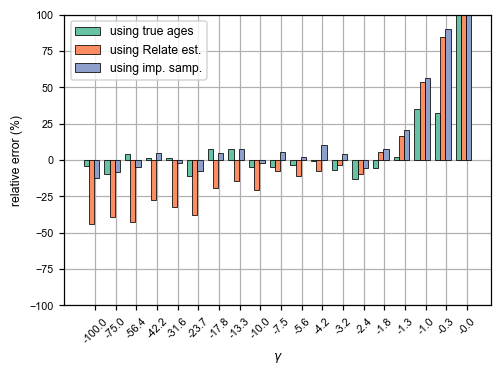

In [427]:
## plotting the difference in values as found using the true age, Relate estimate, importance sampling
listofgamflt = -np.array(listofgam[:20],dtype='float')
width = 0.5
plt.bar(np.arange(19)-width/2, (reswage[:-1,0]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#66c2a5',width = width/2, lw=0.5, edgecolor = 'black', label='using true ages')
plt.bar(np.arange(19), (reswage[:-1,1]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#fc8d62',width = width/2,lw=.5, edgecolor = 'black', label='using Relate est.')
plt.bar(np.arange(19) + width/2, (reswage[:-1,2]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#8da0cb', lw=.5,width = width/2, edgecolor = 'black', label='using imp. samp.')
plt.xticks(np.arange(19) + width/3,np.round(listofgamflt[:-1],1),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('relative error (%)'); plt.grid(); plt.ylim((-100,100))
# plt.scatter(listofgamflt,(reswage[:,0]-listofgamflt)/listofgamflt,color='g',label='using true ages')
# plt.scatter(listofgamflt,(reswage[:,1]-listofgamflt)/listofgamflt,color='b',label='using Relate est.')
# plt.scatter(listofgamflt,(reswage[:,2]-listofgamflt)/listofgamflt,color='grey',label='using imp. samp.'); 

In [435]:
# width = 0.5
# plt.bar(np.arange(20)-width/2, reswage[:,0]/2-listofgamflt, color = '#66c2a5',width = width/2, lw=0.5, edgecolor = 'black', label='using true ages')
# plt.bar(np.arange(20), reswage[:,1]/2-listofgamflt, color = '#fc8d62',width = width/2, lw=0.5, edgecolor = 'black', label='using Relate est.')
# plt.bar(np.arange(20) + width/2, reswage[:,2]/2-listofgamflt, color = '#8da0cb', width = width/2, lw=0.5, edgecolor = 'black', label='using imp. samp.')
# plt.xticks(np.arange(20) + width/3,np.round(listofgamflt,2),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('signed error'); plt.grid(); 

array([-192.604, -112.501, -174.938])

In [535]:
## reading in results from midway3 
# finalres2 = pd.read_csv('finalRes2.csv',delimiter=',')
# finalres2

# ta = np.reshape(finalres2.iloc[:,2].tolist(),(-1,20),order='F')[[0,8,16,19],:]
# rm = np.reshape(finalres2.iloc[:,3].tolist(),(-1,20),order='F')[[0,8,16,19],:]
# ims = np.reshape(finalres2.iloc[:,4].tolist(),(-1,20),order='F')[[0,8,16,19],:]
# fo = np.reshape(finalres2.iloc[:,5].tolist(),(-1,20),order='F')[[0,8,16,19],:]

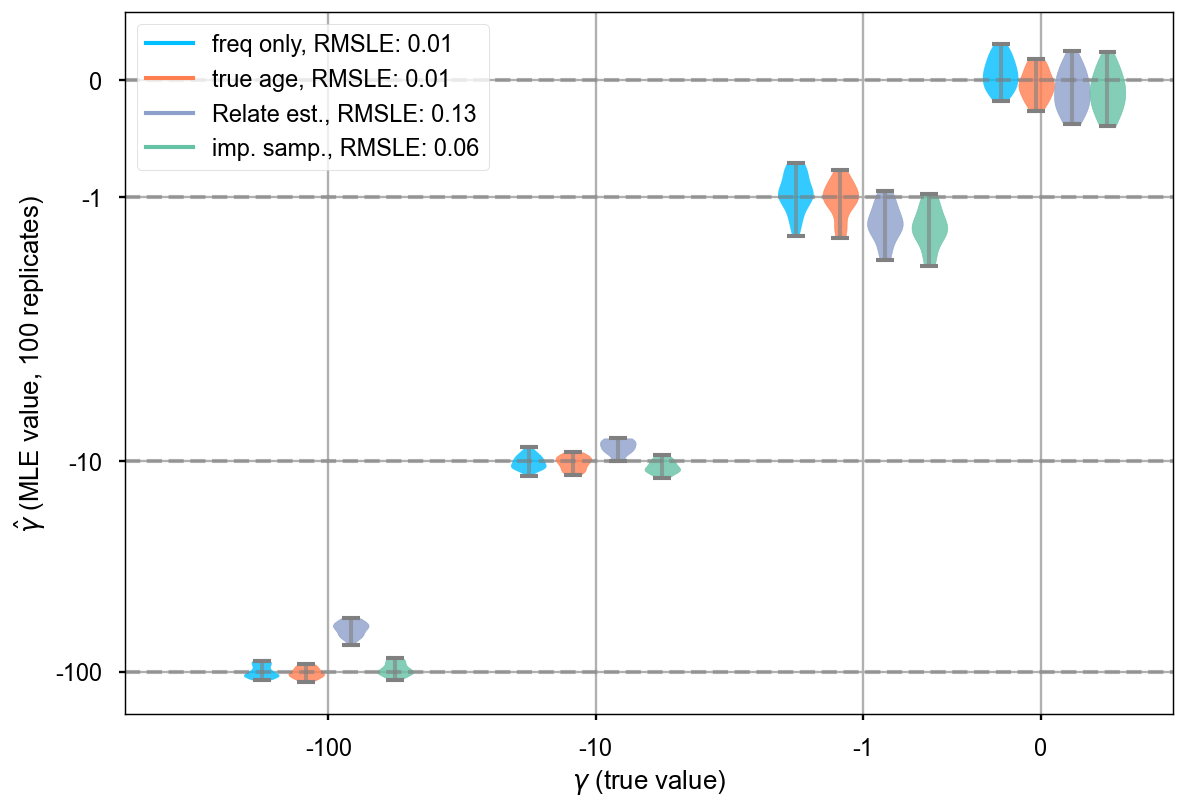

In [538]:
# np.mean((ta[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0)
# np.mean((ta[:-1,].T-listofgamflt[::3])*100/listofgamflt[:-1][::3],axis=0)
# plt.plot(listofgamflt,np.std(fo.T,axis=0)/np.std(ta.T,axis=0),'ko', alpha=0.7); plt.plot(listofgamflt,np.std(fo.T,axis=0)/np.std(ims.T,axis=0),'bo', alpha=0.7)
# plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)

    plt.setp(bp['bodies'][2], color='#8da0cb', alpha=0.8)

    plt.setp(bp['bodies'][3], color='#66c2a5', alpha=0.8)

fig = plt.figure(dpi=130)
plt.style.use('seaborn-talk')
ax = plt.axes()
s = np.array([-100,-10,-1,0])
#-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1]#np.array([1,10,100]) 

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    posn = [1,1.5,2,2.5,4,4.5,5,5.5,7,7.5,8,8.5,9.3,9.7,10.1,10.5]
    vp = plt.violinplot([fo[i,:],ta[i,:],rm[i,:],ims[i,:]],positions=[posn[4*i],posn[4*i+1],posn[4*i+2],posn[4*i+3]], widths=0.4,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.75,4.75,7.75,9.75]); ax.set_xticklabels(np.ravel(s.tolist())); 
ax.set_yscale('symlog'); ax.set_yticks(s,labels=[-100,-10,-1,0]); 

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); hC, = plt.plot(0,0,color='#8da0cb'); hS, = plt.plot(0,0,color='#66c2a5'); 
plt.xlabel(r'$\gamma$ (true value)'); plt.ylabel(r'$\hat \gamma$ (MLE value, 100 replicates)'); plt.legend((hB, hR),('freq only','freq & age'),loc='upper left')
plt.legend((hB, hR, hC, hS),('freq only, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-fo[:-1,:],axis=1)))**2))), 'true age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-ta[:-1,:],axis=1)))**2))), 'Relate est., RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-rm[:-1,:],axis=1)))**2))), 'imp. samp., RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-ims[:-1,:],axis=1)))**2)))),loc='upper left'); plt.grid()
# plt.savefig("../figs/MLEfreqage2.pdf")

(-50.0, 50.0)

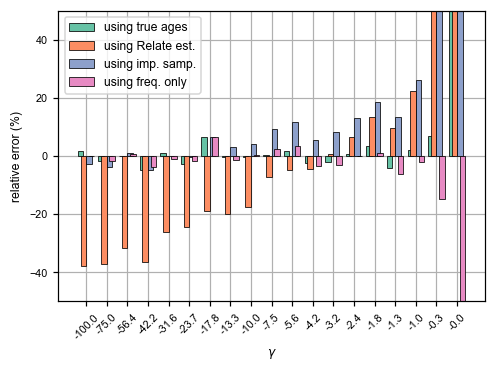

In [513]:
# np.mean((ta.T-listofgamflt)**2,axis=0), np.mean((rm.T-listofgamflt)**2,axis=0), np.mean((fo.T-listofgamflt)**2,axis=0), np.mean((ims.T-listofgamflt)**2,axis=0)
# np.std(ta.T-listofgamflt,axis=0), np.std(rm.T-listofgamflt,axis=0), np.std(fo.T-listofgamflt,axis=0), np.std(ims.T-listofgamflt,axis=0)
# width = 0.8
# plt.bar(3*np.arange(19)-width,np.mean((ta[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0),color = '#66c2a5',width = width,lw=0.5, edgecolor = 'black', label='using true ages')
# plt.bar(3*np.arange(19)-width/2,np.mean((rm[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#fc8d62',width = width,lw=.5, edgecolor = 'black', label='using Relate est.')
# plt.bar(3*np.arange(19)+width/2,np.mean((ims[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#8da0cb', lw=.5,width = width, edgecolor = 'black', label='using imp. samp.')
# plt.bar(3*np.arange(19)+width,np.mean((fo[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#e78ac3',width = width,lw=.5, edgecolor = 'black', label='using freq. only')
# plt.xticks(3*np.arange(19),np.round(listofgamflt[:-1],1),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('relative error (%)'); plt.grid(); plt.ylim((-50,50))